In [ ]:
import os
import numpy as np
import requests
from lovely_numpy import Lo

In [ ]:
from tidygrad.tensor import Tensor
from tidygrad.functional import sigmoid
from tidygrad.utils.datasets import load_mnist
from tidygrad.utils.grad_check import grad_check
from matplotlib import pyplot as plt

In [ ]:
# | eval: false

(x_train, y_train), (x_test, y_test) = load_mnist()


LR = 0.01
BS = 32

INT_DIM = 128


w1 = Tensor(np.random.randn(784, INT_DIM) * 1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")

w2 = Tensor(np.random.randn(INT_DIM, 10) * 1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")


def MM(inputs, params, debug=list()):
    x, y = inputs
    w1, b1, w2 = params
    z1 = sigmoid(x.mmul(w1, "z1")+ b1)
    z2 = z1.mmul(w2, "z2")

    preds = sigmoid(z2)

    return preds


def MM_with_loss(inputs, params, debug=list()):
    x, y = inputs

    preds = MM(inputs, params, debug=debug)

    ones = Tensor(np.ones_like(preds.data), "ones")

    loss_1 = y.mul(preds.log(), "loss_1")
    loss_2 = ones.sub(y).mul(ones.sub(preds, "loss_2").log())
    loss = loss_1.add(loss_2, "loss").sum().neg("loss")
    # loss = loss.mul(Tensor(np.array(1 / x.data.shape[0])), "loss")

    return loss


idxs = np.random.choice(len(x_train), BS, replace=False)
x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255, "x")
y_np = y_train[idxs][:, None]
y_np = np.eye(10)[y_np.reshape(-1)]  # one-hot encode y

y = Tensor(y_np.astype(float), "y")

debug = []

loss = MM_with_loss((x, y), (w1, b1, w2), debug=[])
loss.backward()

# print(b1, *debug)

# Grad check does not work because of the exp/log numerical instability
# grad_check(MM_with_loss, (x, y), (w1, b1, w2), eps=1e-5)

In [ ]:
# | eval: false
np.seterr(all="warn")

# over-fitting on 1 batch

metrics = {
    "loss" : [],
    "acc" : [],
    "val_loss" : [],
    "val_acc" : [],
    "iter": [],
}

avg_loss = 0
n_accum = 0
for i in range(1,10000):    
    n_accum += 1
    idxs = np.random.choice(len(x_train), BS, replace=False)
    x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255 - 0.5, "x")
    y_np = y_train[idxs][:, None]
    y_np = np.eye(10)[y_np.reshape(-1)]

    y = Tensor(y_np.astype(float), "y")

    # One-hot encoding y

    debug = []
    loss = MM_with_loss((x, y), (w1, b1, w2), debug)
    # (z1, z2, preds, diff, l) = debug

    loss.backward()

    if np.isnan(w1.grad).any() or np.isnan(b1.grad).any() or np.isnan(w2.grad).any():
        w1.grad = np.zeros_like(w1.grad)
        b1.grad = np.zeros_like(b1.grad)
        w2.grad = np.zeros_like(w2.grad)
    
    w1.data -= LR * w1.grad
    b1.data -= LR * b1.grad
    w2.data -= LR * w2.grad
    # b2.data -= LR * b2.grad

    w1.grad = np.zeros_like(w1.grad)
    b1.grad = np.zeros_like(b1.grad)
    w2.grad = np.zeros_like(w2.grad)
    # b2.grad = np.zeros_like(b2.grad)
    avg_loss += loss.data
    
    
    if i % 1000 == 0:
        avg_loss /= n_accum
        n_accum = 0

        preds = MM((x, y), (w1, b1, w2))
        accuracy = np.mean(preds.data.argmax(1) == y_np.argmax(1))

    
        x = Tensor(x_test.reshape(len(x_test), 28 * 28) / 255 - 0.5, "x")
        y_np = y_test[:, None]
        y_np = np.eye(10)[y_np.reshape(-1)]
        y = Tensor(y_np.astype(float), "y")

        preds = MM((x, y), (w1, b1, w2))
        val_loss = MM_with_loss((x, y), (w1, b1, w2))
        val_accuracy = np.mean(preds.data.argmax(1) == y_np.argmax(1))
        print(f"Loss: {avg_loss:.2f} Accuracy: {accuracy:.2f} Val Loss: {loss.data:.2f} Val Accuracy: {val_accuracy:.2f}")
        metrics["loss"].append(avg_loss)
        metrics["acc"].append(accuracy)
        metrics["val_loss"].append(val_loss.data)
        metrics["val_acc"].append(val_accuracy)
        metrics["iter"].append(i)

        avg_loss = 0

Loss: 48.68 Accuracy: 0.97 Val Loss: 17.89 Val Accuracy: 0.86
Loss: 26.72 Accuracy: 0.94 Val Loss: 21.61 Val Accuracy: 0.89
Loss: 22.23 Accuracy: 0.91 Val Loss: 34.11 Val Accuracy: 0.90
Loss: 19.10 Accuracy: 0.94 Val Loss: 11.92 Val Accuracy: 0.91
Loss: 17.73 Accuracy: 0.88 Val Loss: 25.33 Val Accuracy: 0.92
Loss: 16.42 Accuracy: 0.91 Val Loss: 22.58 Val Accuracy: 0.93
Loss: 15.29 Accuracy: 1.00 Val Loss: 6.29 Val Accuracy: 0.93
Loss: 14.33 Accuracy: 1.00 Val Loss: 7.20 Val Accuracy: 0.93
Loss: 13.70 Accuracy: 0.97 Val Loss: 17.12 Val Accuracy: 0.93


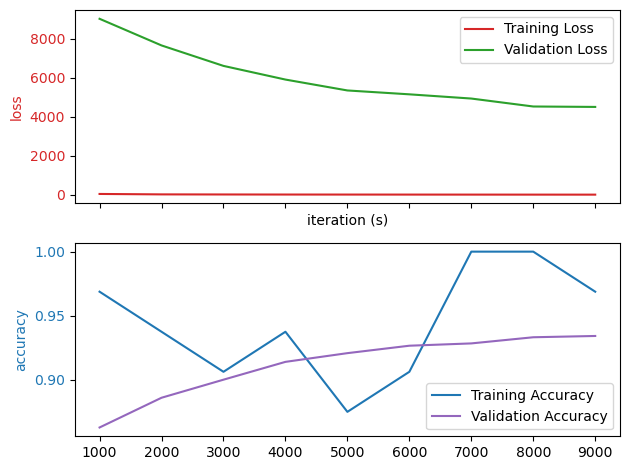

In [ ]:
# | eval: false

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

color = 'tab:red'
ax1.set_xlabel('iteration (s)')
ax1.set_ylabel('loss', color=color)
ax1.plot(metrics["iter"], metrics["loss"], color=color, label='Training Loss')
ax1.plot(metrics["iter"], metrics["val_loss"], color='tab:green', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(metrics["iter"], metrics["acc"], color=color, label='Training Accuracy')
ax2.plot(metrics["iter"], metrics["val_acc"], color='tab:purple', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
from tidygrad.functional import BCE_loss

In [ ]:

(x_train, y_train), (x_test, y_test) = load_mnist()


LR = 0.01
BS = 32

INT_DIM = 128


w1 = Tensor(np.random.randn(784, INT_DIM) * 1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")

w2 = Tensor(np.random.randn(INT_DIM, 10) * 1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")


def MM(inputs, params, debug=list()):
    x, y = inputs
    w1, b1, w2 = params
    z1 = sigmoid(x.mmul(w1, "z1")+ b1)
    z2 = z1.mmul(w2, "z2")

    # preds = sigmoid(z2)

    return z2


def MM_with_loss(inputs, params, debug=list()):
    x, y = inputs

    logits = MM(inputs, params, debug=debug)

    loss = -BCE_loss(logits, y).sum()

    # ones = Tensor(np.ones_like(preds.data), "ones")

    # loss_1 = y.mul(preds.log(), "loss_1")
    # loss_2 = ones.sub(y).mul(ones.sub(preds, "loss_2").log())
    # loss = loss_1.add(loss_2, "loss").sum().neg("loss")
    # loss = loss.mul(Tensor(np.array(1 / x.data.shape[0])), "loss")

    return loss


idxs = np.random.choice(len(x_train), BS, replace=False)
x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255, "x")
y_np = y_train[idxs][:, None]
y_np = np.eye(10)[y_np.reshape(-1)]  # one-hot encode y

y = Tensor(y_np.astype(float), "y")

debug = []

loss = MM_with_loss((x, y), (w1, b1, w2), debug=[])
loss.backward()

In [ ]:
# | eval: false
np.seterr(all="warn")

# over-fitting on 1 batch

metrics = {
    "loss" : [],
    "acc" : [],
    "val_loss" : [],
    "val_acc" : [],
    "iter": [],
}

avg_loss = 0
n_accum = 0
for i in range(1,10000):    
    n_accum += 1
    idxs = np.random.choice(len(x_train), BS, replace=False)
    x = Tensor(x_train[idxs].reshape(BS, 28 * 28) / 255 - 0.5, "x")
    y_np = y_train[idxs][:, None]
    y_np = np.eye(10)[y_np.reshape(-1)]

    y = Tensor(y_np.astype(float), "y")

    # One-hot encoding y

    debug = []
    loss = MM_with_loss((x, y), (w1, b1, w2), debug)
    # (z1, z2, preds, diff, l) = debug

    loss.backward()

    if np.isnan(w1.grad).any() or np.isnan(b1.grad).any() or np.isnan(w2.grad).any():
        w1.grad = np.zeros_like(w1.grad)
        b1.grad = np.zeros_like(b1.grad)
        w2.grad = np.zeros_like(w2.grad)
    
    w1.data -= LR * w1.grad
    b1.data -= LR * b1.grad
    w2.data -= LR * w2.grad
    # b2.data -= LR * b2.grad

    w1.grad = np.zeros_like(w1.grad)
    b1.grad = np.zeros_like(b1.grad)
    w2.grad = np.zeros_like(w2.grad)
    # b2.grad = np.zeros_like(b2.grad)
    avg_loss += loss.data
    
    
    if i % 1000 == 0:
        avg_loss /= n_accum
        n_accum = 0

        preds = MM((x, y), (w1, b1, w2))
        accuracy = np.mean(preds.data.argmax(1) == y_np.argmax(1))

    
        x = Tensor(x_test.reshape(len(x_test), 28 * 28) / 255 - 0.5, "x")
        y_np = y_test[:, None]
        y_np = np.eye(10)[y_np.reshape(-1)]
        y = Tensor(y_np.astype(float), "y")

        preds = MM((x, y), (w1, b1, w2))
        val_loss = MM_with_loss((x, y), (w1, b1, w2))
        val_accuracy = np.mean(preds.data.argmax(1) == y_np.argmax(1))
        print(f"Loss: {avg_loss:.2f} Accuracy: {accuracy:.2f} Val Loss: {loss.data:.2f} Val Accuracy: {val_accuracy:.2f}")
        metrics["loss"].append(avg_loss)
        metrics["acc"].append(accuracy)
        metrics["val_loss"].append(val_loss.data)
        metrics["val_acc"].append(val_accuracy)
        metrics["iter"].append(i)

        avg_loss = 0

Loss: 47.05 Accuracy: 0.84 Val Loss: 28.19 Val Accuracy: 0.87
Loss: 26.15 Accuracy: 0.97 Val Loss: 29.76 Val Accuracy: 0.90
Loss: 21.08 Accuracy: 1.00 Val Loss: 8.59 Val Accuracy: 0.91
Loss: 18.98 Accuracy: 0.97 Val Loss: 12.82 Val Accuracy: 0.91
Loss: 17.01 Accuracy: 0.91 Val Loss: 22.93 Val Accuracy: 0.92
Loss: 16.00 Accuracy: 0.94 Val Loss: 21.11 Val Accuracy: 0.92
Loss: 14.57 Accuracy: 0.97 Val Loss: 9.54 Val Accuracy: 0.93
Loss: 14.17 Accuracy: 1.00 Val Loss: 13.99 Val Accuracy: 0.93
Loss: 13.58 Accuracy: 0.97 Val Loss: 13.84 Val Accuracy: 0.93
